In [1]:
import pandas as pd
import re
import contractions

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

import spacy

nlp = spacy.load('en_core_web_sm')

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Dictionary: https://amazon-reviews-2023.github.io/

In [2]:
data_file_path = 'Software.jsonl'
data_chunks = pd.read_json(data_file_path, lines=True, chunksize=10000)

meta_data_file_path = 'meta_Software.jsonl'
meta_data = pd.read_json(meta_data_file_path, lines=True)

In [3]:
data = pd.DataFrame()

for chunk in data_chunks :
    data = chunk.copy()
    break

In [4]:
data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True


In [5]:
data.shape

(10000, 10)

In [6]:
# Getting product name from metadata using parent_asin as the key

data = data.merge(meta_data[['title', 'parent_asin']], on='parent_asin', how='left', suffixes=('_review', '_product'))

data.head()

,rating,title_review,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,title_product
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False,"McAfee Total Protection 2022 [Old Version], 10..."
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True,The Simpsons: Tapped Out
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True,Flashlight
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True,Gold Fish Casino Slots – Free Online Slot Mach...
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True,SkyBalance by Nik Wallenda


In [7]:
data.isnull().sum()      # Checking for null values

rating               0
title_review         0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
title_product        0
dtype: int64

In [8]:
data['rating'].value_counts(normalize=True)*100 # Checking imbalance in target variable

5    51.42
4    16.75
1    13.85
3    10.89
2     7.09
Name: rating, dtype: float64

### The target variable is imbalanced. Evaluation metric will be ROC AUC

In [9]:
def only_emoji(text):
    # Regular expression pattern to match emojis
    emoji_pattern = re.compile(
        "^[" 
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002500-\U00002BEF"  # Chinese characters
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010ffff"
        "\u2640-\u2642" 
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"  # Dingbats
        "\u3030"
        "]+", flags=re.UNICODE)
    
    return bool(emoji_pattern.search(text))

In [10]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002500-\U00002BEF"  # Chinese characters
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010ffff"
        "\u2640-\u2642" 
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"  # Dingbats
        "\u3030"
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

In [11]:
emoji_mask = data['text'].apply(only_emoji)                  
data.drop(data['text'][emoji_mask].index, inplace=True)      # Removing rows with reviews only as emoji(s)
data['text'] = data['text'].apply(remove_emojis)             # Removing emojis from sentences containing text+emojis

In [12]:
data.shape

(9952, 11)

In [13]:
data['text'] = data['text'].str.lower()              # Lowering case

In [14]:
data['text'] = data['text'].apply(lambda x: contractions.fix(x))                 # Expanding stuff like I'd to I would, etc

data['text']

0                                      mcaffee is malware
1       i love playing tapped out because it is fun to...
2       i love this flashlight app!  it really illumin...
3                                one of my favorite games
4       cute game. i am not that good at it but my kid...
                              ...                        
9995    i canceled cable and subscribed to youtube tv ...
9996        after being downloaded it would not even open
9997    i really like this game. the speed is perfect ...
9998    really love playing this game. but such a sham...
9999    can play these  slots for hours. nice variety ...
Name: text, Length: 9952, dtype: object

In [15]:
def remove_unwanted_punctuation(text):
    pattern = r"[!\"#$%&\'()*+,-/:;?@\[\\\]^_{|}~]"
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [16]:
data['text'] = data['text'].apply(remove_unwanted_punctuation)          # Removing punctuations

data['text']

0                                      mcaffee is malware
1       i love playing tapped out because it is fun to...
2       i love this flashlight app  it really illumina...
3                                one of my favorite games
4       cute game i am not that good at it but my kids...
                              ...                        
9995    i canceled cable and subscribed to youtube tv ...
9996        after being downloaded it would not even open
9997    i really like this game the speed is perfect s...
9998    really love playing this game but such a shame...
9999    can play these  slots for hours nice variety t...
Name: text, Length: 9952, dtype: object

In [17]:
data['text'] = data['text'].apply(lambda x: " ".join(x.split()))      # Removing extra spaces

data['text']

0                                      mcaffee is malware
1       i love playing tapped out because it is fun to...
2       i love this flashlight app it really illuminat...
3                                one of my favorite games
4       cute game i am not that good at it but my kids...
                              ...                        
9995    i canceled cable and subscribed to youtube tv ...
9996        after being downloaded it would not even open
9997    i really like this game the speed is perfect s...
9998    really love playing this game but such a shame...
9999    can play these slots for hours nice variety to...
Name: text, Length: 9952, dtype: object

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts

In [19]:
x_train, x_test, y_train, y_test = tts(data['text'], data['rating'], test_size=0.2, shuffle=True, stratify=data['rating'], random_state=44)

In [20]:
countvector = CountVectorizer(ngram_range=(1,2))
traindataset = countvector.fit_transform(x_train)

In [21]:
randomclassifier = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=44, class_weight='balanced')
randomclassifier.fit(traindataset, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=20, random_state=44)

In [25]:
test_dataset = countvector.transform(x_test)
predictions = randomclassifier.predict(test_dataset)

In [26]:
train_dataset = countvector.transform(x_train)
predictions_train = randomclassifier.predict(train_dataset)

In [27]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

### Predicting on test data

In [28]:
matrix=confusion_matrix(y_test,predictions)
print(matrix)
score=accuracy_score(y_test,predictions)
print(score)
report=classification_report(y_test,predictions)
print(report)

[[139   9   5   8 115]
 [ 30  25   9   8  70]
 [ 36  11  22  19 128]
 [ 21   2   8  45 259]
 [ 23  14   9  59 917]]
0.5765946760421898
              precision    recall  f1-score   support

           1       0.56      0.50      0.53       276
           2       0.41      0.18      0.25       142
           3       0.42      0.10      0.16       216
           4       0.32      0.13      0.19       335
           5       0.62      0.90      0.73      1022

    accuracy                           0.58      1991
   macro avg       0.46      0.36      0.37      1991
weighted avg       0.52      0.58      0.52      1991



### Predicting on training data

In [29]:
matrix=confusion_matrix(y_train,predictions_train)
print(matrix)
score=accuracy_score(y_train,predictions_train)
print(score)
report=classification_report(y_train,predictions_train)
print(report)

[[1089    9    4    1    3]
 [  16  546    3    2    0]
 [  26   26  797    6    9]
 [  13   10    6 1261   50]
 [  20   37   17   41 3969]]
0.9624419042833815
              precision    recall  f1-score   support

           1       0.94      0.98      0.96      1106
           2       0.87      0.96      0.91       567
           3       0.96      0.92      0.94       864
           4       0.96      0.94      0.95      1340
           5       0.98      0.97      0.98      4084

    accuracy                           0.96      7961
   macro avg       0.94      0.96      0.95      7961
weighted avg       0.96      0.96      0.96      7961



In [30]:
test_string = pd.Series(['This product is ridiculous', ])

test_dataset = countvector.transform(test_string)
predictions = randomclassifier.predict(test_dataset)
predictions

array([5], dtype=int64)

### The model is overfitting need to use either a different model or use pruning with decision tree

In [ ]:
data['text_lemmatized'] = data['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

data['text_lemmatized']

In [ ]:
x_train, x_test, y_train, y_test = tts(data['text_lemmatized'], data['rating'], test_size=0.2, shuffle=True, stratify=data['rating'], random_state=44)

In [30]:
countvector=CountVectorizer(ngram_range=(1,2))
traindataset=countvector.fit_transform(x_train)
traindataset.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [31]:
classifier=DecisionTreeClassifier(criterion='entropy', random_state=44, class_weight='balanced')
classifier.fit(traindataset, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=44)

In [32]:
path = classifier.cost_complexity_pruning_path(traindataset, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [33]:
ccp_alphas

array([ 0.00000000e+00, -1.30104261e-18,  4.70630730e-20, ...,
        2.73679717e-02,  2.93657123e-02,  8.05192726e-02])

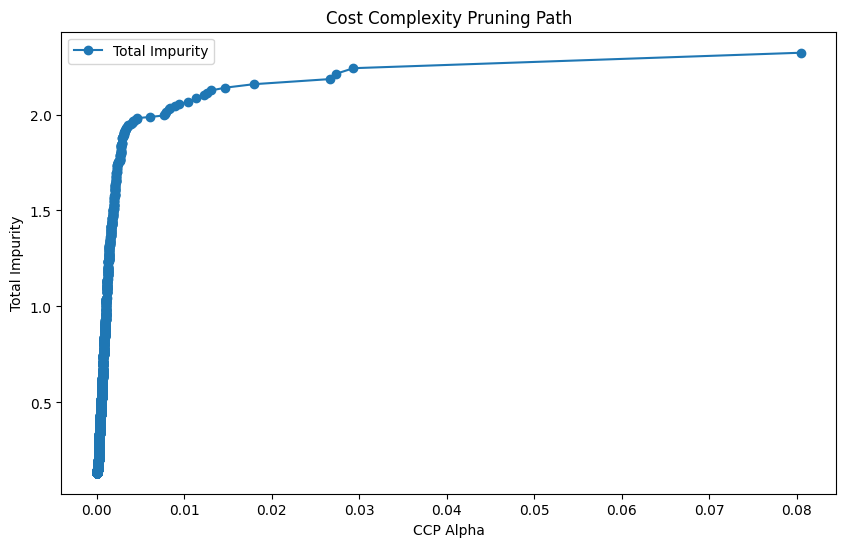

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker='o', label='Total Impurity')
plt.xlabel('CCP Alpha')
plt.ylabel('Total Impurity')
plt.title('Cost Complexity Pruning Path')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

pruned_trees = []

for ccp_alpha in ccp_alphas[: 2]:
    pruned_tree = DecisionTreeClassifier(ccp_alpha=np.abs(ccp_alpha), criterion='entropy', random_state=44, class_weight='balanced')
    pruned_tree.fit(traindataset, y_train)
    pruned_trees.append(pruned_tree)


In [88]:

test_dataset = countvector.transform(x_test)
predictions = randomclassifier.predict(test_dataset)

In [ ]:
train_dataset = countvector.transform(x_train)
predictions_train = randomclassifier.predict(test_dataset)

In [89]:
matrix=confusion_matrix(y_test,predictions)
print(matrix)
score=accuracy_score(y_test,predictions)
print(score)
report=classification_report(y_test,predictions)
print(report)

[[137   9   9   8 113]
 [ 34  23  10   5  70]
 [ 38   9  27  31 111]
 [ 15   2   7  57 254]
 [ 24  15   9  60 914]]
0.5816172777498745
              precision    recall  f1-score   support

           1       0.55      0.50      0.52       276
           2       0.40      0.16      0.23       142
           3       0.44      0.12      0.19       216
           4       0.35      0.17      0.23       335
           5       0.63      0.89      0.74      1022

    accuracy                           0.58      1991
   macro avg       0.47      0.37      0.38      1991
weighted avg       0.53      0.58      0.53      1991

